In [1]:
cases_annotated = ['https://caselaw.nationalarchives.gov.uk/ewca/crim/2003/3',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2003/2243',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2004/2278',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2005/1983',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2006/694',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2006/1155',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2007/1530',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2008/553',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2009/1431',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2010/712',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2012/720',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2013/801',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2013/1649',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2016/52',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2017/1851',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2018/1766',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2019/362',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2020/499',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2022/83',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2023/231']

In [2]:
%matplotlib inline

from tqdm import tqdm
import requests
from requests.auth import HTTPBasicAuth
import json
from collections import defaultdict, Counter
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
import re
from copy import deepcopy
import numpy as np
import pathlib
import jsonlines
import os
from collections import defaultdict
import ast

In [3]:
API_TOKEN = '6879-Ws7xpjMTkjjUocr0Nzga0_yYkb-9sF9XmRHaKPQScCc'
USERNAME = 'stirunagari' # CharisBechan1' #'stirunagari'
GROUP_ID = 'JuDDges_Charis1' # 'JuDDges'


# Headers for the API request
headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Accept': 'application/vnd.hypothesis.v1+json',
    'Content-Type': 'application/json;charset=utf-8'
}

# Base URL for Hypothesis API
user_url = 'https://api.hypothes.is/api/profile'

In [22]:
import requests
import json
import csv

# Headers for the API request
GROUP_NAME = 'JuDDges_Charis1'  # Replace with your actual group name

headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Accept': 'application/vnd.hypothesis.v1+json',
    'Content-Type': 'application/json;charset=utf-8'
}

# Base URL for Hypothesis API
user_url = 'https://api.hypothes.is/api/profile'

def get_user_information():
    try:
        response = requests.get(user_url, headers=headers)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
        
        user_info = response.json()
        print(f"User Information: {json.dumps(user_info, indent=2)}")
        return user_info
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except requests.exceptions.ConnectionError as conn_err:
        print(f"Connection error occurred: {conn_err}")
    except requests.exceptions.Timeout as timeout_err:
        print(f"Timeout error occurred: {timeout_err}")
    except requests.exceptions.RequestException as req_err:
        print(f"An error occurred: {req_err}")
    
    return None

def get_group_annotations(api_token, group_id):
    SORT_BY = 'updated'
    LIMIT = 200

    headers = {
        'Authorization': f'Bearer {api_token}',
        'Accept': 'application/vnd.hypothesis.v1+json',
        'Content-Type': 'application/json;charset=utf-8'
    }
    payload = {'group': group_id, 'sort': SORT_BY, 'limit': LIMIT}
    
    results = []
    counter = 0

    while True:
        response = requests.get('https://api.hypothes.is/api/search', params=payload, headers=headers)
        response.raise_for_status()
        data = response.json()

        annotations = data['rows']
        if not annotations:
            break

        for anno in annotations:
            counter += 1
            results.append(extract_annotations(anno))

        if counter >= data['total']:
            break

        payload['search_after'] = annotations[-1]['updated']

    assert data['total'] == counter, f"Expected {data['total']} annotations, but extracted {counter}"
    return results

def extract_annotations(annotation):
    """Extract annotation information from each Hypothesis annotation"""
    try:
        anno = {
            'source': annotation['target'][0]['source'],
            'exact': None,
            'comment': annotation.get('text', ''),
            'tags': annotation.get('tags', [])
        }

        target = annotation['target'][0]
        if 'selector' in target:
            for selector in target['selector']:
                if selector['type'] == 'TextQuoteSelector':
                    anno['exact'] = selector['exact']

    except Exception as e:
        print(f"Error extracting annotation: {e}")
        print(annotation)
        raise
    return anno

def save_annotations_to_csv(annotations, filename='annotations.csv'):
    keys = ['source', 'exact', 'comment', 'tags']
    with open(filename, 'w', newline='', encoding='utf-8') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(annotations)

# Fetch user information
user_information = get_user_information()

if user_information:
    groups = user_information['groups']
    all_annotations = []

    # Fetch annotations for the specified group
    for group in groups:
        if group['name'] == GROUP_NAME:
            group_id = group['id']
            print(f"Fetching annotations for group: {group['name']} ({group_id})")
            annotations = get_group_annotations(api_token=API_TOKEN, group_id=group_id)
            all_annotations.extend(annotations)
            break

    print(f"Total annotations fetched: {len(all_annotations)}")

    # Save annotations to CSV
    save_annotations_to_csv(all_annotations)
    print("Annotations saved to annotations.csv")
else:
    print("Failed to retrieve user information.")


User Information: {
  "userid": "acct:stirunagari@hypothes.is",
  "authority": "hypothes.is",
  "groups": [
    {
      "name": "Public",
      "id": "__world__",
      "public": true
    },
    {
      "name": "JuDDges",
      "id": "1yeVRNek",
      "public": false,
      "url": "https://api.hypothes.is/groups/1yeVRNek/juddges"
    },
    {
      "name": "JuDDges_Charis1",
      "id": "ebKd44jY",
      "public": false,
      "url": "https://api.hypothes.is/groups/ebKd44jY/juddges-charis1"
    },
    {
      "name": "JuDDGes_Intra_Charis",
      "id": "rKV4Ev5p",
      "public": false,
      "url": "https://api.hypothes.is/groups/rKV4Ev5p/juddges-intra-charis"
    },
    {
      "name": "JuDDges_Intra_Vili",
      "id": "Qb9zgyQY",
      "public": false,
      "url": "https://api.hypothes.is/groups/Qb9zgyQY/juddges-intra-vili"
    },
    {
      "name": "JuDDges_Vah",
      "id": "BjRM6pBd",
      "public": false,
      "url": "https://api.hypothes.is/groups/BjRM6pBd/juddges-vah"
    

In [23]:
# Read the annotations CSV file
filename = 'annotations.csv'
annotations_df = pd.read_csv(filename)


In [24]:
annotations_df

,source,exact,comment,tags
0,https://caselaw.nationalarchives.gov.uk/ewca/c...,27th February 2006 the offender pleaded guilty...,NaN,"['Confess/Plead', 'PleaPoint', 'ConvictPleaDate']"
1,https://caselaw.nationalarchives.gov.uk/ewca/c...,dismiss both appeals against conviction.,After appeals & retrials,"['ReasonDismiss', 'AppealOutcome']"
2,https://caselaw.nationalarchives.gov.uk/ewca/c...,Ali knew Karen Price from a school that they a...,NaN,['OffVicRelation']
3,https://caselaw.nationalarchives.gov.uk/ewca/c...,Karen Price and D were absconders,Unemployed,['VicJobOffence']
4,https://caselaw.nationalarchives.gov.uk/ewca/c...,worked as a doorman.,NaN,['OffJobOffence']
...,...,...,...,...
369,https://caselaw.nationalarchives.gov.uk/ewca/c...,Crown Court at Truro,-,['ConvCourtType']
370,https://caselaw.nationalarchives.gov.uk/ewca/c...,jury,-,['Jurytrial']
371,https://caselaw.nationalarchives.gov.uk/ewca/c...,He gave evidence that he had seen Mr Davies pu...,Eye-witness testimony.,['DefEvidTypeTrial']
372,https://caselaw.nationalarchives.gov.uk/ewca/c...,contempt of court.,-,['ConvictOffence']


In [25]:
def convert_to_case(url):
    parts = url.split('/')
    year = parts[-2]
    case_number = parts[-1]
    return f"[{year}] EWCA Crim {case_number}"

# Apply the function to the 'source' column to create the 'Case' column
annotations_df['Case'] = annotations_df['source'].apply(convert_to_case)
annotations_df['tags'] = annotations_df['tags'].apply(ast.literal_eval)

In [26]:
annotations_df

,source,exact,comment,tags,Case
0,https://caselaw.nationalarchives.gov.uk/ewca/c...,27th February 2006 the offender pleaded guilty...,NaN,"[Confess/Plead, PleaPoint, ConvictPleaDate]",[2007] EWCA Crim 1530
1,https://caselaw.nationalarchives.gov.uk/ewca/c...,dismiss both appeals against conviction.,After appeals & retrials,"[ReasonDismiss, AppealOutcome]",[2016] EWCA Crim 52
2,https://caselaw.nationalarchives.gov.uk/ewca/c...,Ali knew Karen Price from a school that they a...,NaN,[OffVicRelation],[2016] EWCA Crim 52
3,https://caselaw.nationalarchives.gov.uk/ewca/c...,Karen Price and D were absconders,Unemployed,[VicJobOffence],[2016] EWCA Crim 52
4,https://caselaw.nationalarchives.gov.uk/ewca/c...,worked as a doorman.,NaN,[OffJobOffence],[2016] EWCA Crim 52
...,...,...,...,...,...
369,https://caselaw.nationalarchives.gov.uk/ewca/c...,Crown Court at Truro,-,[ConvCourtType],[2020] EWCA Crim 499
370,https://caselaw.nationalarchives.gov.uk/ewca/c...,jury,-,[Jurytrial],[2020] EWCA Crim 499
371,https://caselaw.nationalarchives.gov.uk/ewca/c...,He gave evidence that he had seen Mr Davies pu...,Eye-witness testimony.,[DefEvidTypeTrial],[2020] EWCA Crim 499
372,https://caselaw.nationalarchives.gov.uk/ewca/c...,contempt of court.,-,[ConvictOffence],[2020] EWCA Crim 499


In [27]:
set(cases_annotated) - set(annotations_df['source'].unique().tolist())

{'https://caselaw.nationalarchives.gov.uk/ewca/crim/2003/2243',
 'https://caselaw.nationalarchives.gov.uk/ewca/crim/2018/1766'}

In [34]:
annotations_df['Case'].unique()

array(['[2007] EWCA Crim 1530', '[2016] EWCA Crim 52',
       '[2012] EWCA Crim 720', '[2019] EWCA Crim 362',
       '[2017] EWCA Crim 1851', '[2010] EWCA Crim 712',
       '[2008] EWCA Crim 553', '[2006] EWCA Crim 694',
       '[2005] EWCA Crim 1983', '[2004] EWCA Crim 2278',
       '[2022] EWCA Crim 83', '[2023] EWCA Crim 231',
       '[2013] EWCA Crim 1649', '[2013] EWCA Crim 801',
       '[2009] EWCA Crim 1431', '[2006] EWCA Crim 1155',
       '[2003] EWCA Crim 3', '[2020] EWCA Crim 499'], dtype=object)

In [28]:
annotations_df[annotations_df['Case']=='[2016] EWCA Crim 52']

,source,exact,comment,tags,Case
1,https://caselaw.nationalarchives.gov.uk/ewca/c...,dismiss both appeals against conviction.,After appeals & retrials,"[ReasonDismiss, AppealOutcome]",[2016] EWCA Crim 52
2,https://caselaw.nationalarchives.gov.uk/ewca/c...,Ali knew Karen Price from a school that they a...,NaN,[OffVicRelation],[2016] EWCA Crim 52
3,https://caselaw.nationalarchives.gov.uk/ewca/c...,Karen Price and D were absconders,Unemployed,[VicJobOffence],[2016] EWCA Crim 52
4,https://caselaw.nationalarchives.gov.uk/ewca/c...,worked as a doorman.,NaN,[OffJobOffence],[2016] EWCA Crim 52
5,https://caselaw.nationalarchives.gov.uk/ewca/c...,court held this was credible and admissible ev...,Evidence admissible,"[VoirDire, VoirDireOutcome]",[2016] EWCA Crim 52
6,https://caselaw.nationalarchives.gov.uk/ewca/c...,(both consultant psychologists) as to Ali’s in...,NaN,"[OffMentalOffence, DefEvidTypeTrial]",[2016] EWCA Crim 52
7,https://caselaw.nationalarchives.gov.uk/ewca/c...,Rose J had directed the jury in clear terms th...,First appeal judgement,[JuryInstruct],[2016] EWCA Crim 52
8,https://caselaw.nationalarchives.gov.uk/ewca/c...,ALAN CHARLTON AND IDRIS ALI,"2 individual male appellents, offenders","[Appellent, OffSex, Co-defendants/co-accused, ...",[2016] EWCA Crim 52
9,https://caselaw.nationalarchives.gov.uk/ewca/c...,Ali’s cell,Custody,[RemandDecision],[2016] EWCA Crim 52
10,https://caselaw.nationalarchives.gov.uk/ewca/c...,"an account of glue-sniffing, drug-taking",NaN,"[OffIntoxOffence, VicIntoxOffence]",[2016] EWCA Crim 52


In [36]:
# Read the annotations CSV file

def drop_empty_columns(df):
    # Drop columns that contain only 'NA' or empty strings
    return df.loc[:, (df != 'NA').any(axis=0) & (df != '').any(axis=0)]


filename = 'data/Curation_in_detail - Charis.csv'
curation_sheet_df = pd.read_csv(filename)
curation_sheet_df = drop_empty_columns(curation_sheet_df)

In [37]:
curation_sheet_df



,Coding,Description,tag_name,[2003] EWCA Crim 3,[2003] EWCA Crim 758,[2003] EWCA Crim 2243,[2003] EWCA Crim 1,[2003] EWCA Crim 486,[2004] EWCA Crim 1717,[2004] EWCA Crim 2038,...,[2023] EWCA Crim 1040,[2023] EWCA Crim 231,[2023] EWCA Crim 1235,[2023] EWCA Crim 491,[2023] EWCA Crim 1131,[2024] EWCA Crim 36,[2024] EWCA Crim 108,[2024] EWCA Crim 238,[2024] EWCA Crim 544,[2024] EWCA Crim 304
0,ConvCourtType Court Type where Offender was Co...,Magistrates’ court/Crown court,ConvCourtType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ConvCourtName(s) Court Name(s) where Offender ...,Text (List all courts if convicted/pled guilty...,ConvCourtName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ConvictPleaDate Conviction/Guilty Plea Date(s),Numeric (List all),ConvictPleaDate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Was there a Jurytrial?\nIf YES, JuryDecisionType","Yes/No/Don’t know\nIf YES, Unanimous/Majority/...",Jurytrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,JuryDecisionType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ConvictOffence What Offence(s) was Offender Co...,Text (List all),ConvictOffence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,AcquitOffence What Offence(s) was Offender Acq...,N/A OR Text (List all),AcquitOffence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Did Offender Confess/Plead Guilty? \nIf YES, a...","Yes/No\nIf YES, in police presence/at first co...",Confess/Plead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,PleaPoint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,What was the RemandDecision for Offender?\nIf ...,Unconditional Bail/Conditional Bail/ Remanded ...,RemandDecision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# # Loop through each unique case in annotations_df
# for case in annotations_df['Case'].unique():
#     # Filter the rows for the current case in annotations_df
#     case_rows = annotations_df[annotations_df['Case'] == case]
    
#     # Loop through each row for the current case
#     for _, row in case_rows.iterrows():
#         tags = row['tags']
#         exact = row['exact']
#         comment = row['comment']
        
#         # Loop through each tag
#         for tag in tags:
#             # Find the matching row in curation_sheet_df
#             tag_row = curation_sheet_df[curation_sheet_df['tag_name'] == tag]
            
#             if not tag_row.empty:
#                 tag_index = tag_row.index[0]
                
#                 # Update the curation_sheet_df if the cell is blank
#                 if pd.isna(curation_sheet_df.at[tag_index, case]):
#                     curation_sheet_df.at[tag_index, case] = f"Exact: {exact}\n\n, Comment: {comment}"


import pandas as pd

# Ensure the columns in curation_sheet_df can hold string values
for case in annotations_df['Case'].unique():
    if case in curation_sheet_df.columns:
        curation_sheet_df[case] = curation_sheet_df[case].astype(object)

# Loop through each unique case in annotations_df
for case in annotations_df['Case'].unique():
    # Filter the rows for the current case in annotations_df
    case_rows = annotations_df[annotations_df['Case'] == case]
    
    # Loop through each row for the current case
    for _, row in case_rows.iterrows():
        tags = row['tags']
        exact = row['exact']
        comment = row['comment']
        
        # Loop through each tag
        for tag in tags:
            # Find the matching row in curation_sheet_df
            tag_row = curation_sheet_df[curation_sheet_df['tag_name'] == tag]
            
            if not tag_row.empty:
                tag_index = tag_row.index[0]
                
                # Check if the cell already contains a value
                current_value = curation_sheet_df.at[tag_index, case]
                new_value = f"Exact: {exact}\n\n, Comment: {comment}"
                
                if pd.isna(current_value) or current_value == "":
                    # If the cell is empty, assign the new value
                    curation_sheet_df.at[tag_index, case] = new_value
                else:
                    # If the cell is not empty, append the new value
                    curation_sheet_df.at[tag_index, case] += f"\n\n{new_value}"



In [43]:
tags

['Appellent']

In [44]:
curation_sheet_df

,Coding,Description,tag_name,[2003] EWCA Crim 3,[2003] EWCA Crim 758,[2003] EWCA Crim 2243,[2003] EWCA Crim 1,[2003] EWCA Crim 486,[2004] EWCA Crim 1717,[2004] EWCA Crim 2038,...,[2023] EWCA Crim 1040,[2023] EWCA Crim 231,[2023] EWCA Crim 1235,[2023] EWCA Crim 491,[2023] EWCA Crim 1131,[2024] EWCA Crim 36,[2024] EWCA Crim 108,[2024] EWCA Crim 238,[2024] EWCA Crim 544,[2024] EWCA Crim 304
0,ConvCourtType Court Type where Offender was Co...,Magistrates’ court/Crown court,ConvCourtType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"Exact: Crown Court at Liverpool\n\n, Comment: ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ConvCourtName(s) Court Name(s) where Offender ...,Text (List all courts if convicted/pled guilty...,ConvCourtName,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"Exact: Crown Court at Liverpool\n\n, Comment: ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ConvictPleaDate Conviction/Guilty Plea Date(s),Numeric (List all),ConvictPleaDate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"Exact: 6th February 2015,\n\n, Comment: nan\n\...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Was there a Jurytrial?\nIf YES, JuryDecisionType","Yes/No/Don’t know\nIf YES, Unanimous/Majority/...",Jurytrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,JuryDecisionType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ConvictOffence What Offence(s) was Offender Co...,Text (List all),ConvictOffence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"Exact: pleaded guilty to murder.\n\n, Comment:...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,AcquitOffence What Offence(s) was Offender Acq...,N/A OR Text (List all),AcquitOffence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Did Offender Confess/Plead Guilty? \nIf YES, a...","Yes/No\nIf YES, in police presence/at first co...",Confess/Plead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"Exact: pleaded guilty to murder.\n\n, Comment:...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,PleaPoint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"Exact: 6th February 2015,\n\n, Comment: nan\n\...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,What was the RemandDecision for Offender?\nIf ...,Unconditional Bail/Conditional Bail/ Remanded ...,RemandDecision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Exact: life imprisonment with a minimum term o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Automate across all users and file_names (use this script)

In [2]:
cases_annotated = ['https://caselaw.nationalarchives.gov.uk/ewca/crim/2003/3',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2003/2243',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2004/2278',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2005/1983',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2006/694',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2006/1155',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2007/1530',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2008/553',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2009/1431',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2010/712',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2012/720',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2013/801',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2013/1649',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2016/52',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2017/1851',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2018/1766',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2019/362',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2020/499',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2022/83',
'https://caselaw.nationalarchives.gov.uk/ewca/crim/2023/231']

def convert_to_case(url):
    parts = url.split('/')
    year = parts[-2]
    case_number = parts[-1]
    return f"[{year}] EWCA Crim {case_number}"

In [3]:
interested_cases = [convert_to_case(x) for x in cases_annotated]
interested_cases

['[2003] EWCA Crim 3',
 '[2003] EWCA Crim 2243',
 '[2004] EWCA Crim 2278',
 '[2005] EWCA Crim 1983',
 '[2006] EWCA Crim 694',
 '[2006] EWCA Crim 1155',
 '[2007] EWCA Crim 1530',
 '[2008] EWCA Crim 553',
 '[2009] EWCA Crim 1431',
 '[2010] EWCA Crim 712',
 '[2012] EWCA Crim 720',
 '[2013] EWCA Crim 801',
 '[2013] EWCA Crim 1649',
 '[2016] EWCA Crim 52',
 '[2017] EWCA Crim 1851',
 '[2018] EWCA Crim 1766',
 '[2019] EWCA Crim 362',
 '[2020] EWCA Crim 499',
 '[2022] EWCA Crim 83',
 '[2023] EWCA Crim 231']

In [4]:
import requests
import json
import csv

API_TOKEN = '6879-Ws7xpjMTkjjUocr0Nzga0_yYkb-9sF9XmRHaKPQScCc'


# Headers for the API request
GROUP_NAMES = ['JuDDges_Vah', 'JuDDges', 'JuDDges_Charis1']  # Replace with your actual group names

headers = {
    'Authorization': f'Bearer {API_TOKEN}',
    'Accept': 'application/vnd.hypothesis.v1+json',
    'Content-Type': 'application/json;charset=utf-8'
}

# Base URL for Hypothesis API
user_url = 'https://api.hypothes.is/api/profile'

def get_user_information():
    try:
        response = requests.get(user_url, headers=headers)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
        
        user_info = response.json()
        print(f"User Information: {json.dumps(user_info, indent=2)}")
        return user_info
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except requests.exceptions.ConnectionError as conn_err:
        print(f"Connection error occurred: {conn_err}")
    except requests.exceptions.Timeout as timeout_err:
        print(f"Timeout error occurred: {timeout_err}")
    except requests.exceptions.RequestException as req_err:
        print(f"An error occurred: {req_err}")
    
    return None

def get_group_annotations(api_token, group_id):
    SORT_BY = 'updated'
    LIMIT = 200

    headers = {
        'Authorization': f'Bearer {api_token}',
        'Accept': 'application/vnd.hypothesis.v1+json',
        'Content-Type': 'application/json;charset=utf-8'
    }
    payload = {'group': group_id, 'sort': SORT_BY, 'limit': LIMIT}
    
    results = []
    counter = 0

    while True:
        response = requests.get('https://api.hypothes.is/api/search', params=payload, headers=headers)
        response.raise_for_status()
        data = response.json()

        annotations = data['rows']
        if not annotations:
            break

        for anno in annotations:
            counter += 1
            results.append(extract_annotations(anno))

        if counter >= data['total']:
            break

        payload['search_after'] = annotations[-1]['updated']

    assert data['total'] == counter, f"Expected {data['total']} annotations, but extracted {counter}"
    return results

def extract_annotations(annotation):
    """Extract annotation information from each Hypothesis annotation"""
    try:
        anno = {
            'user': annotation['user'],
            'source': annotation['target'][0]['source'],
            'exact': None,
            'comment': annotation.get('text', ''),
            'tags': annotation.get('tags', [])
        }

        target = annotation['target'][0]
        if 'selector' in target:
            for selector in target['selector']:
                if selector['type'] == 'TextQuoteSelector':
                    anno['exact'] = selector['exact']

    except Exception as e:
        print(f"Error extracting annotation: {e}")
        print(annotation)
        raise
    return anno

def save_annotations_to_csv(annotations, filename):
    keys = ['user', 'source', 'exact', 'comment', 'tags']
    with open(filename, 'w', newline='', encoding='utf-8') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(annotations)

# Fetch user information
user_information = get_user_information()

if user_information:
    groups = user_information['groups']
    all_annotations = []
    group_ids = [group['id'] for group in groups if group['name'] in GROUP_NAMES]

    # Fetch annotations for each group
    for group_id in group_ids:
        print(f"Fetching annotations for group ID: {group_id}")
        annotations = get_group_annotations(api_token=API_TOKEN, group_id=group_id)
        all_annotations.extend(annotations)

    print(f"Total annotations fetched: {len(all_annotations)}")

    # Group annotations by user
    annotations_by_user = {}
    for annotation in all_annotations:
        user = annotation['user']
        if user not in annotations_by_user:
            annotations_by_user[user] = []
        annotations_by_user[user].append(annotation)

    # Save annotations for each user to separate CSV files
    for user, user_annotations in annotations_by_user.items():
        filename = f"{user.replace(':', '_')}_annotations.csv"
        save_annotations_to_csv(user_annotations, filename)
        print(f"Annotations for user {user} saved to {filename}")

else:
    print("Failed to retrieve user information.")


User Information: {
  "userid": "acct:stirunagari@hypothes.is",
  "authority": "hypothes.is",
  "groups": [
    {
      "name": "Public",
      "id": "__world__",
      "public": true
    },
    {
      "name": "JuDDges",
      "id": "1yeVRNek",
      "public": false,
      "url": "https://api.hypothes.is/groups/1yeVRNek/juddges"
    },
    {
      "name": "JuDDges_Charis1",
      "id": "ebKd44jY",
      "public": false,
      "url": "https://api.hypothes.is/groups/ebKd44jY/juddges-charis1"
    },
    {
      "name": "JuDDGes_Intra_Charis",
      "id": "rKV4Ev5p",
      "public": false,
      "url": "https://api.hypothes.is/groups/rKV4Ev5p/juddges-intra-charis"
    },
    {
      "name": "JuDDges_Intra_Vili",
      "id": "Qb9zgyQY",
      "public": false,
      "url": "https://api.hypothes.is/groups/Qb9zgyQY/juddges-intra-vili"
    },
    {
      "name": "JuDDges_Vah",
      "id": "BjRM6pBd",
      "public": false,
      "url": "https://api.hypothes.is/groups/BjRM6pBd/juddges-vah"
    

In [23]:
import pandas as pd
import ast

def process_files(annotation_files, curation_files):
    def convert_to_case(url):
        parts = url.split('/')
        year = parts[-2]
        case_number = parts[-1]
        return f"[{year}] EWCA Crim {case_number}"

    for annotation_file, curation_file in zip(annotation_files, curation_files):
        # Read the annotations CSV file
        annotations_df = pd.read_csv(annotation_file, na_filter=False)
        annotations_df['Case'] = annotations_df['source'].apply(convert_to_case)
        annotations_df['tags'] = annotations_df['tags'].apply(ast.literal_eval)

        # Correcting the tag name from "Appellent" to "Appellant" within each list
        annotations_df['tags'] = annotations_df['tags'].apply(lambda tags: ["Appellant" if tag == "Appellent" else tag for tag in tags])

        # Read the curation sheet CSV file
        curation_sheet_df = pd.read_csv(curation_file, na_filter=False)
        
        # Preserve the first two columns
        first_two_columns = curation_sheet_df.iloc[:, :2]
        
        # List of interested cases
        interested_case = annotations_df['Case'].unique().tolist()

        # Keep only columns that are in the interested_case list
        columns_to_keep = ['tag_name'] + [col for col in curation_sheet_df.columns if col in interested_case]
        curation_sheet_df = curation_sheet_df[columns_to_keep]

        # Ensure the columns in curation_sheet_df can hold string values
        for case in annotations_df['Case'].unique():
            if case in curation_sheet_df.columns:
                curation_sheet_df[case] = curation_sheet_df[case].astype(object)

        # Loop through each unique case in annotations_df
        for case in annotations_df['Case'].unique():
            # Filter the rows for the current case in annotations_df
            case_rows = annotations_df[annotations_df['Case'] == case]
            
            # Loop through each row for the current case
            for _, row in case_rows.iterrows():
                tags = row['tags']
                exact = row['exact']
                comment = row['comment']
                
                # Loop through each tag
                for tag in tags:
                    # Find the matching row in curation_sheet_df
                    tag_row = curation_sheet_df[curation_sheet_df['tag_name'] == tag]
                    
                    if not tag_row.empty:
                        tag_index = tag_row.index[0]
                        
                        # Check if the cell already contains a value
                        current_value = curation_sheet_df.at[tag_index, case]
                        new_value = f"Exact: {exact};\n\n Comment: {comment}"
                        
                        if pd.isna(current_value) or current_value == "":
                            # If the cell is empty, assign the new value
                            curation_sheet_df.at[tag_index, case] = new_value
                        else:
                            # If the cell is not empty, append the new value
                            curation_sheet_df.at[tag_index, case] += f"\n\n{new_value}"

        # Concatenate the preserved columns with the updated curation sheet
        curation_sheet_df = pd.concat([first_two_columns, curation_sheet_df], axis=1)

        # Save the updated curation sheet
        output_filename = f"updated_{curation_file.split('/')[-1]}"
        curation_sheet_df.to_csv(output_filename, index=False)
        print(f"Updated curation sheet saved to {output_filename}")

# List of annotation CSV files
filenames_annoated = ['acct_CharisBechan1@hypothes.is_annotations.csv', 'acct_vah@hypothes.is_annotations.csv']

# List of curation sheet CSV files
filename_curation_in_detail = ['data/Curation_in_detail - Charis.csv', 'data/Curation_in_detail - Vili.csv',]

# Run the processing function
process_files(filenames_annoated, filename_curation_in_detail)



Updated curation sheet saved to updated_Curation_in_detail - Charis.csv
Updated curation sheet saved to updated_Curation_in_detail - Vili.csv


# Annotations analysis

In [24]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Load the updated curation sheets
file1 = 'updated_Curation_in_detail - Vili.csv'
file2 = 'updated_Curation_in_detail - Charis.csv'

df1 = pd.read_csv(file1, na_filter=False)
df2 = pd.read_csv(file2, na_filter=False)

# Ensure the dataframes have the same columns
common_columns = df1.columns.intersection(df2.columns)
df1 = df1[common_columns]
df2 = df2[common_columns]

# Initialize lists to hold comparison results
tag_names = []
agreement = []
partial_agreement = []

def extract_content(text):
    if 'Exact:' in text and 'Comment:' in text:
        parts = text.split('Comment:')
        exact = parts[0].replace('Exact:', '').strip()
        comment = parts[1].strip()
        return exact, comment
    return '', ''

# Compare tags in both dataframes
for tag in df1['tag_name']:
    if tag in df2['tag_name'].values:
        tag_names.append(tag)
        
        # Extract the columns with case annotations
        case_columns = common_columns.drop(['tag_name'])
        
        # Count matches and partial matches
        total_cases = len(case_columns)
        exact_matches = 0
        partial_matches = 0
        
        for case in case_columns:
            val1 = df1.loc[df1['tag_name'] == tag, case].values[0]
            val2 = df2.loc[df2['tag_name'] == tag, case].values[0]
            
            exact1, comment1 = extract_content(val1)
            exact2, comment2 = extract_content(val2)
            
            if val1 == val2:  # Exact match, including 'NA' and empty
                exact_matches += 1
            elif (exact1 in exact2 or exact2 in exact1 or comment1 in comment2 or comment2 in comment1) and (val1 != '' and val2 != ''):  # Partial match
                partial_matches += 1
        
        agreement.append(exact_matches / total_cases)
        partial_agreement.append((exact_matches + partial_matches) / total_cases)

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Tag Name': tag_names,
    'Percentage Agreed': agreement,
    'Partial Agreement': partial_agreement
})

# Display the results
print(comparison_df)

                    Tag Name  Percentage Agreed  Partial Agreement
0              ConvCourtType           0.090909           0.909091
1              ConvCourtName           0.500000           0.909091
2            ConvictPleaDate           0.090909           0.772727
3                  Jurytrial           0.181818           0.863636
4           JuryDecisionType           0.409091           0.409091
5             ConvictOffence           0.090909           0.590909
6              AcquitOffence           0.181818           0.818182
7              Confess/Plead           0.409091           0.863636
8                  PleaPoint           0.227273           0.363636
9             RemandDecision           0.272727           0.772727
10         RemandCustodyTime           0.272727           0.272727
11             SentCourtType           0.136364           0.863636
12             SentCourtName           0.318182           0.772727
13                  Sentence           0.136364           0.63

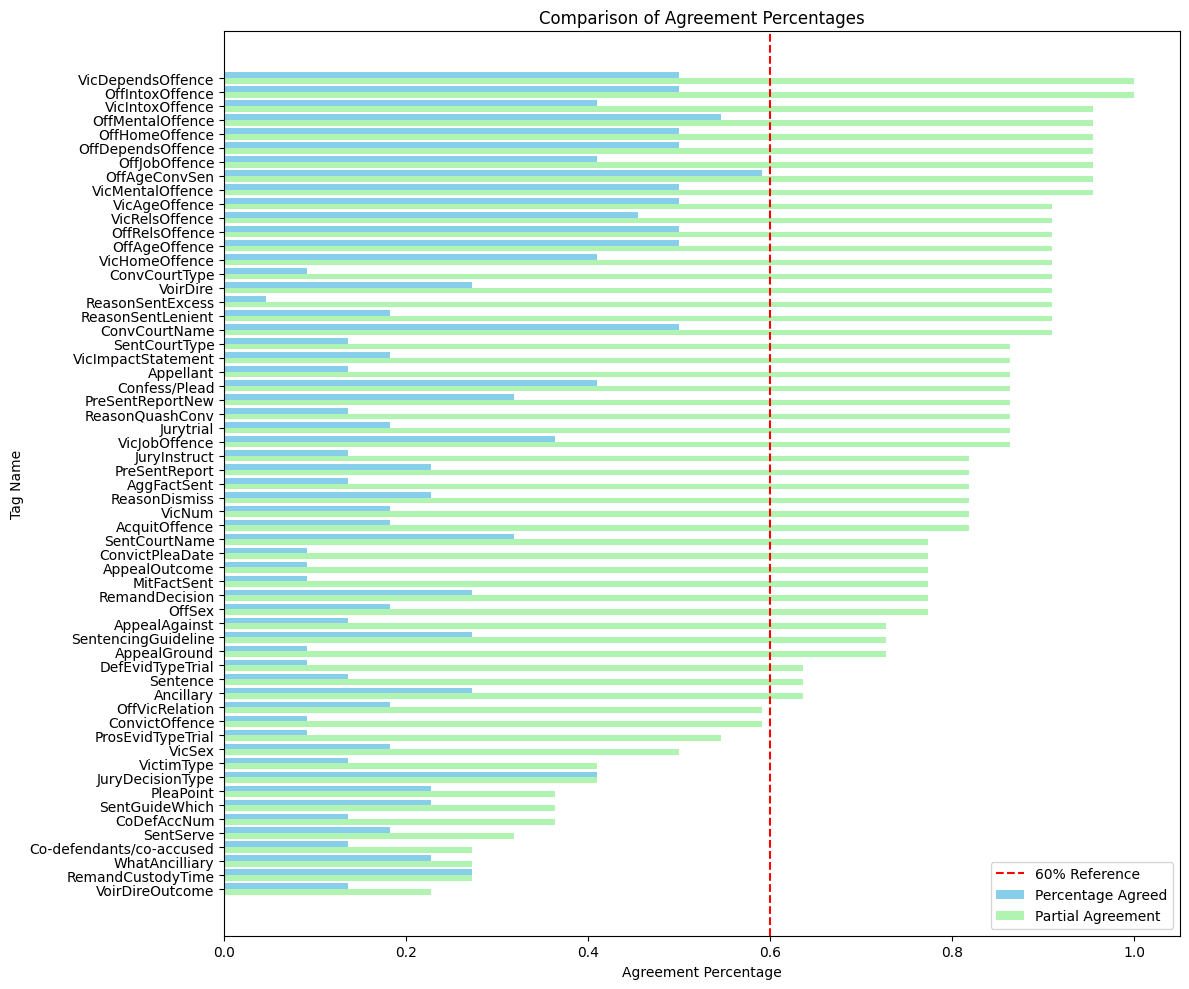

In [25]:
# Save the plot as a PNG file
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
bar_width = 0.4
sorted_df = comparison_df.sort_values(by='Partial Agreement', ascending=False)
index = range(len(sorted_df))

plt.barh(index, sorted_df['Percentage Agreed'], bar_width, color='skyblue', label='Percentage Agreed')
plt.barh([i + bar_width for i in index], sorted_df['Partial Agreement'], bar_width, color='lightgreen', alpha=0.7, label='Partial Agreement')

# Adding space between variable names
plt.yticks([i + bar_width / 2 for i in index], sorted_df['Tag Name'])
plt.xlabel('Agreement Percentage')
plt.ylabel('Tag Name')
plt.title('Comparison of Agreement Percentages')

# Adding a reference line at 60%
plt.axvline(x=0.6, color='red', linestyle='--', label='60% Reference')

plt.legend()
plt.gca().invert_yaxis()  # To have the highest values on top
plt.tight_layout()

# Save the plot to a file
plt.savefig('comparison_agreement_percentages.png')
plt.show()


In [26]:
import pandas as pd

# Load the updated curation dataframes
charis_df = pd.read_csv('updated_Curation_in_detail - Charis.csv', na_filter=False)
vili_df = pd.read_csv('updated_Curation_in_detail - Vili.csv', na_filter=False)

def adjust_values(text):
    if 'Exact:' in text or 'Comment:' in text:
        parts = text.split('\n')
        combined = []
        exact = None
        comment = None
        
        for part in parts:
            part = part.strip()
            if part.startswith('Exact:'):
                if exact is not None:
                    combined.append(f"Exact: {exact}\n\nComment: {comment if comment is not None else ''}")
                exact = part.split('Exact:', 1)[1].strip()
                comment = None  # Reset comment for new pair
            elif part.startswith('Comment:'):
                comment = part.split('Comment:', 1)[1].strip()
                if exact is not None:
                    combined.append(f"Exact: {exact}\n\nComment: {comment}")
                    exact = None  # Reset exact for next pair
                    comment = None  # Reset comment for next pair

        if exact is not None:
            combined.append(f"Exact: {exact}\n\nComment: {comment if comment is not None else ''}")

        return ";\n\n".join(combined)
    else:
        return text

# Apply the adjustment function to each dataframe
for col in charis_df.columns[3:]:
    charis_df[col] = charis_df[col].apply(adjust_values)

for col in vili_df.columns[3:]:
    vili_df[col] = vili_df[col].apply(adjust_values)

# Rename columns to distinguish between Charis and Vili
charis_columns = {col: f"{col} (Charis)" for col in charis_df.columns[3:]}
vili_columns = {col: f"{col} (Vili)" for col in vili_df.columns[3:]}

charis_df.rename(columns=charis_columns, inplace=True)
vili_df.rename(columns=vili_columns, inplace=True)

# Merge the dataframes on the first three columns
merged_df = pd.merge(charis_df.iloc[:, :3], charis_df.iloc[:, 3:], left_index=True, right_index=True)
merged_df = pd.merge(merged_df, vili_df.iloc[:, 3:], left_index=True, right_index=True)

# Ensure Charis columns follow corresponding Vili columns
merged_columns = list(merged_df.columns[:3])  # Keep the first three columns
for col in charis_df.columns[3:]:
    if col in merged_df.columns:
        vili_col = col.replace('(Charis)', '(Vili)')
        if vili_col in merged_df.columns:
            merged_columns.append(col)
            merged_columns.append(vili_col)
        else:
            merged_columns.append(col)

merged_df = merged_df[merged_columns]

# Save the merged dataframe to a CSV file
merged_df.to_csv('merged_curation_comparison.csv', index=False)
print("Merged curation dataframe saved to merged_curation_comparison.csv")


Merged curation dataframe saved to merged_curation_comparison.csv


In [ ]:
# Sort the dataframe by Percentage Agreed in descending order
# sorted_df = comparison_df.sort_values(by='Partial Agreement', ascending=False)

# # Plot the sorted dataframe
# plt.figure(figsize=(10, 8))
# plt.barh(sorted_df['Tag Name'], sorted_df['Percentage Agreed'], color='skyblue', label='Percentage Agreed')
# plt.barh(sorted_df['Tag Name'], sorted_df['Partial Agreement'], color='lightgreen', alpha=0.7, label='Partial Agreement')
# plt.xlabel('Agreement Percentage')
# plt.ylabel('Tag Name')
# plt.title('Comparison of Agreement Percentages')
# plt.legend()
# plt.gca().invert_yaxis()  # To have the highest values on top
# plt.show()